In [216]:
pip install tslearn

Note: you may need to restart the kernel to use updated packages.


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from sklearn.manifold import TSNE
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, mean_squared_error
from sklearn.preprocessing import StandardScaler
from tslearn.metrics import dtw
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer
from scipy.stats import ks_2samp, ttest_ind

### Load TimeGan model

In [46]:
# 1. Load the pre-trained generator model
generator = load_model('saved_models_rnn/best_generator.h5')

# 2. Define parameters
batch_size = 32
sequence_length = 120  # 120 time steps
num_features = 3
column_names = ['temperature_channel1', 'cooling_channel0', 'maxigauge_channel3']

# 3. Generate synthetic data
noise = np.random.normal(size=(batch_size, sequence_length, num_features)).astype(np.float32)
synthetic_data = generator.predict(noise)

# 4. Convert to DataFrame
df_synthetic = pd.DataFrame(
    synthetic_data.reshape(-1, num_features),
    columns=column_names,
    dtype=np.float32
)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


### Enhanced Anomoly Injection

In [47]:
# 4. Define AnomalyInjector class
class EnhancedAnomalyInjector:
    def __init__(self, cooling_group, temp_group, maxigauge_group, physical_constraints=None, points_per_hour=120, min_spacing=10):
        self.cooling_group = cooling_group
        self.temp_group = temp_group
        self.maxigauge_group = maxigauge_group
        self.constraints = physical_constraints or {}
        self.points_per_hour = points_per_hour
        self.min_spacing = min_spacing

    def inject_anomalies(self, df, min_anomalies_per_hour=1, max_anomalies_per_hour=5, min_duration=1, max_duration=15, random_seed=None):
        if random_seed is not None:
            np.random.seed(random_seed)

        df_anomalous = df.copy()
        anomaly_indicator = np.zeros(len(df))
        total_points = len(df)
        n_hours = int(np.ceil(total_points / self.points_per_hour))
        anomalies_per_hour = np.random.randint(min_anomalies_per_hour, max_anomalies_per_hour + 1, size=n_hours)
        anomaly_types = ['shift', 'spike', 'noise', 'freeze', 'drift', 'compound']
        anomaly_probs = [0.25, 0.25, 0.2, 0.1, 0.1, 0.1]

        current_point = 0
        for hour_idx in range(n_hours):
            hour_start = current_point
            hour_end = min(current_point + self.points_per_hour, total_points)
            n_anomalies = anomalies_per_hour[hour_idx]
            candidates = np.arange(hour_start, hour_end - max_duration)

            valid_positions = []
            while len(valid_positions) < n_anomalies and len(candidates) > 0:
                candidate = np.random.choice(candidates)
                if all(abs(candidate - pos) >= self.min_spacing for pos in valid_positions):
                    valid_positions.append(candidate)
                    candidates = candidates[np.abs(candidates - candidate) >= self.min_spacing]
                else:
                    candidates = np.setdiff1d(candidates, [candidate])

            for pos in valid_positions:
                duration = np.random.randint(min_duration, max_duration + 1)
                end_pos = min(pos + duration, hour_end)
                anomaly_type = np.random.choice(anomaly_types, p=anomaly_probs)
                for t in range(pos, end_pos):
                    if anomaly_type == 'shift':
                        self._apply_shift(df_anomalous, t)
                    elif anomaly_type == 'spike':
                        self._apply_spike(df_anomalous, t)
                    elif anomaly_type == 'noise':
                        self._apply_noise(df_anomalous, t)
                    elif anomaly_type == 'freeze':
                        self._apply_freeze(df_anomalous, t)
                    elif anomaly_type == 'drift':
                        self._apply_drift(df_anomalous, t)
                    elif anomaly_type == 'compound':
                        self._apply_spike(df_anomalous, t)
                        self._apply_drift(df_anomalous, t)
                    self._validate_constraints(df_anomalous, t)
                    anomaly_indicator[t] = 1

            current_point = hour_end

        return df_anomalous, anomaly_indicator

    def _apply_shift(self, df, idx):
        group = np.random.choice(['cooling', 'temp', 'maxigauge', 'single'])
        if group == 'cooling':
            shift = np.random.uniform(-5, 5)
            for ch in self.cooling_group:
                df.at[idx, ch] += shift
        elif group == 'temp':
            shift = np.random.uniform(-10, 10)
            for ch in self.temp_group:
                df.at[idx, ch] += shift
        elif group == 'maxigauge':
            shift = np.random.uniform(-100, 100)
            for ch in self.maxigauge_group:
                df.at[idx, ch] += shift
        else:
            ch = np.random.choice(df.columns)
            if ch in self.cooling_group:
                df.at[idx, ch] += np.random.uniform(-5, 5)
            elif ch in self.temp_group:
                df.at[idx, ch] += np.random.uniform(-10, 10)
            else:
                df.at[idx, ch] += np.random.uniform(-100, 100)

    def _apply_spike(self, df, idx):
        ch = np.random.choice(df.columns)
        factor = np.random.choice([-1, 1])
        if ch in self.cooling_group or ch in self.temp_group:
            df.at[idx, ch] *= factor * np.random.uniform(2, 5)
        else:
            df.at[idx, ch] *= factor * np.random.uniform(2, 10)

    def _apply_noise(self, df, idx):
        ch = np.random.choice(df.columns)
        if ch in self.cooling_group:
            df.at[idx, ch] += np.random.normal(0, 2)
        elif ch in self.temp_group:
            df.at[idx, ch] += np.random.normal(0, 40)
        else:
            df.at[idx, ch] += np.random.normal(0, 150)

    def _apply_freeze(self, df, idx):
        ch = np.random.choice(df.columns)
        if idx > 0:
            df.at[idx, ch] = df.at[idx - 1, ch]

    def _apply_drift(self, df, idx):
        ch = np.random.choice(df.columns)
        direction = np.random.choice([-1, 1])
        if ch in self.cooling_group:
            df.at[idx, ch] += direction * np.random.uniform(0.1, 0.5)
        elif ch in self.temp_group:
            df.at[idx, ch] += direction * np.random.uniform(1, 5)
        else:
            df.at[idx, ch] += direction * np.random.uniform(10, 50)

    def _validate_constraints(self, df, idx):
        for ch in df.columns:
            if ch in self.constraints:
                val = df.at[idx, ch]
                df.at[idx, ch] = np.clip(val, self.constraints[ch]['min'], self.constraints[ch]['max'])

In [48]:
# 5. Create an instance of the EnhancedAnomalyInjector
injector = EnhancedAnomalyInjector(
    cooling_group=['cooling_channel0'],
    temp_group=['temperature_channel1'],
    maxigauge_group=['maxigauge_channel3'],
    physical_constraints={
        'temperature_channel1': {'min': -50, 'max': 150},
        'cooling_channel0': {'min': 0, 'max': 100},
        'maxigauge_channel3': {'min': 0, 'max': 1000}
    }
)

df_with_anomalies, anomaly_labels = injector.inject_anomalies(
    df_synthetic,
    min_anomalies_per_hour=1,
    max_anomalies_per_hour=5,
    min_duration=1,
    max_duration=10,
    random_seed=42
)

/var/folders/k8/13s2hdrn4j3c1707gnj300r80000gn/T/ipykernel_6953/3892563809.py:91: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '-0.0033848899660704436' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  df.at[idx, ch] *= factor * np.random.uniform(2, 5)
/var/folders/k8/13s2hdrn4j3c1707gnj300r80000gn/T/ipykernel_6953/3892563809.py:117: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '32.40858602404084' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  df.at[idx, ch] += direction * np.random.uniform(10, 50)
/var/folders/k8/13s2hdrn4j3c1707gnj300r80000gn/T/ipykernel_6953/3892563809.py:91: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '-3.7472457058037856' has dtype inc

In [49]:
# 6. Restore to data original shape
synthetic_data_with_anomalies = df_with_anomalies.values.reshape(batch_size, sequence_length, num_features)
anomaly_labels = anomaly_labels.reshape(batch_size, sequence_length)

Synthetic data with anomalies generated successfully!
Data Shape: (32, 120, 3)
Anomoly ratio: 14.32%


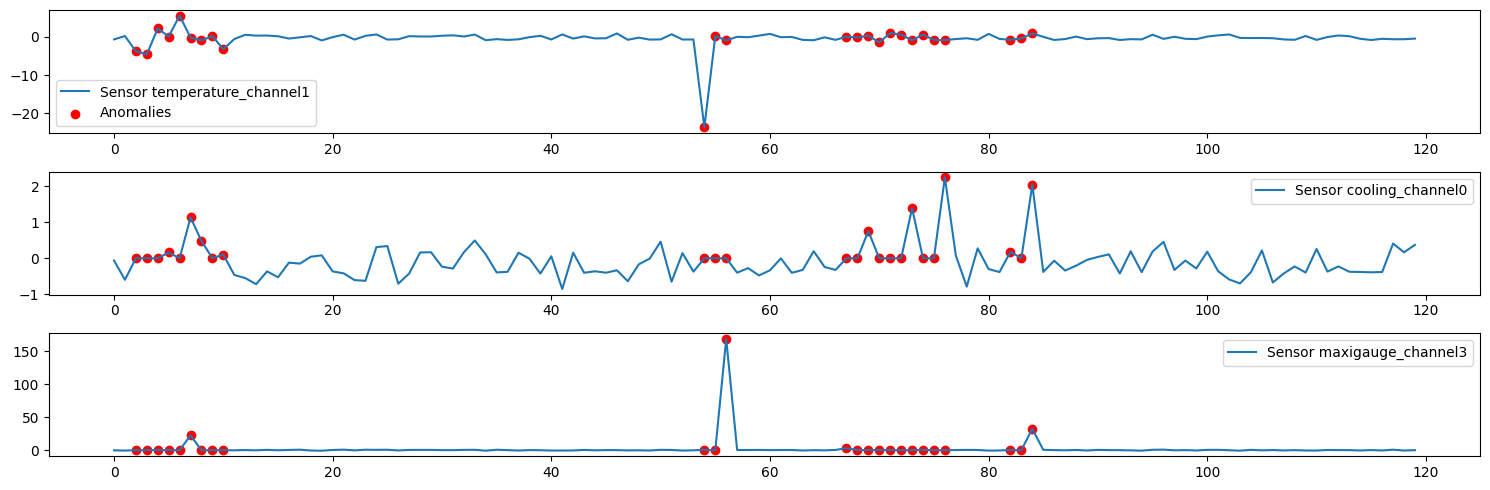

In [50]:
# 7. Visualize the results
print("Synthetic data with anomalies generated successfully!")
print(f"Data Shape: {synthetic_data_with_anomalies.shape}")
print(f"Anomoly ratio: {anomaly_labels.mean():.2%}")

plt.figure(figsize=(15, 5))
for i in range(num_features):
    plt.subplot(num_features, 1, i+1)
    plt.plot(synthetic_data_with_anomalies[0, :, i], label=f'Sensor {column_names[i]}')
    anomalies = np.where(anomaly_labels[0] == 1)[0]
    plt.scatter(anomalies, synthetic_data_with_anomalies[0, anomalies, i],
                color='red', label='Anomalies' if i == 0 else "")
    plt.legend()
plt.tight_layout()
plt.show()

### Evaluation Matrix

#### Load Real Data

In [51]:
# Load dataset
real_data = pd.read_csv("../databases/processed_data/TimeGAN_data.csv")

# Convert datetime column to proper format
real_data['datetime'] = pd.to_datetime(real_data['datetime'])

# Select relevant sensor columns for training
selected_columns = ['cooling_channel10', 'temperature_channel1', 'maxigauge_channel3']
sensor_data = real_data[selected_columns].values  # Convert to numpy array

# Normalize the data to the range [-1, 1]
scaler = MinMaxScaler(feature_range=(-1, 1))
sensor_data_normalized = scaler.fit_transform(sensor_data)

# Define sequence length (e.g., 60 time steps = 30 minutes)
sequence_length = 120

# Function to create overlapping sequences for TimeGAN training
def create_sequences(data, seq_length):
    sequences = []
    for i in range(len(data) - seq_length):
        sequences.append(data[i: i + seq_length])
    return np.array(sequences)

real_data = create_sequences(sensor_data_normalized, sequence_length)

In [52]:
print("Real data shape:", real_data.shape)
print("Synthetic data shape:", synthetic_data.shape)

Real data shape: (68992, 120, 3)
Synthetic data shape: (32, 120, 3)


In [53]:
class TimeSeriesEvaluator:
    def __init__(self, real_data, synthetic_data):
        """
        Parameters:
        - real_data: np.array of shape (N, T, F)
        - synthetic_data: np.array of shape (N, T, F)
        """
        assert real_data.shape == synthetic_data.shape, "Shape mismatch between real and synthetic data."
        self.real = real_data
        self.synthetic = synthetic_data
        self.N, self.T, self.F = real_data.shape

    def average_dtw(self):
        dtw_distances = []
        for real_seq, synth_seq in zip(self.real, self.synthetic):
            dist = 0
            for i in range(self.F):
                dist += dtw(real_seq[:, i], synth_seq[:, i])
            dtw_distances.append(dist / self.F)
        return np.mean(dtw_distances)

    def discriminative_score(self):
        X = np.concatenate([self.real.reshape(self.N, -1), self.synthetic.reshape(self.N, -1)])
        y = np.concatenate([np.ones(self.N), np.zeros(self.N)])  # 1 = real, 0 = synthetic

        X = StandardScaler().fit_transform(X)
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
        clf = LogisticRegression(max_iter=1000).fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        return 1.0 - accuracy_score(y_test, y_pred)  # Lower accuracy = more similarity

    def predictive_score(self, window=5):
        real_mse, synth_mse = [], []
        for data in [self.real, self.synthetic]:
            X, Y = [], []
            for seq in data:
                for t in range(window, self.T):
                    X.append(seq[t-window:t].flatten())
                    Y.append(seq[t])
            X, Y = np.array(X), np.array(Y)
            X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=42)
            reg = LinearRegression().fit(X_train, Y_train)
            Y_pred = reg.predict(X_test)
            mse = mean_squared_error(Y_test, Y_pred)
            if data is self.real:
                real_mse.append(mse)
            else:
                synth_mse.append(mse)
        return np.mean(np.abs(np.array(real_mse) - np.array(synth_mse)))

    def plot_overlay(self, n=5, feature_names=None):
        """
        Plots n samples for each feature (real vs. synthetic).
        """
        for f in range(self.F):
            fig, axes = plt.subplots(n, 1, figsize=(10, 2 * n))
            for i in range(n):
                axes[i].plot(self.real[i, :, f], label='Real')
                axes[i].plot(self.synthetic[i, :, f], label='Synthetic', linestyle='dashed')
                axes[i].legend()
                title = f"Sample {i} - Feature {f}"
                if feature_names and f < len(feature_names):
                    title = f"Sample {i} - {feature_names[f]}"
                axes[i].set_title(title)
            plt.tight_layout()
            plt.show()

    def plot_tsne(self):
        X = np.concatenate([self.real.reshape(self.N, -1), self.synthetic.reshape(self.N, -1)])
        y = np.concatenate([np.ones(self.N), np.zeros(self.N)])
        X = StandardScaler().fit_transform(X)

        X_embedded = TSNE(n_components=2, perplexity=30, random_state=42).fit_transform(X)
        plt.figure(figsize=(8, 6))
        plt.scatter(X_embedded[y == 1, 0], X_embedded[y == 1, 1], label='Real', alpha=0.6, s=10)
        plt.scatter(X_embedded[y == 0, 0], X_embedded[y == 0, 1], label='Synthetic', alpha=0.6, s=10)
        plt.legend()
        plt.title("t-SNE Visualization of Real vs. Synthetic")
        plt.show()

    def evaluate_all(self, feature_names=None):
        print("=== Quantitative Evaluation ===")
        print(f"DTW Score: {self.average_dtw():.4f}")
        print(f"Discriminative Score (1 - Accuracy): {self.discriminative_score():.4f}")
        print(f"Predictive Score (MSE diff): {self.predictive_score():.4f}")
        print("\n=== Qualitative Evaluation ===")
        self.plot_overlay(feature_names=feature_names)
        self.plot_tsne()

In [54]:
class TimeSeriesEvaluator:
    def __init__(self, real_data, synthetic_data):
        assert real_data.shape == synthetic_data.shape, "Shape mismatch between real and synthetic data."
        self.real = real_data
        self.synthetic = synthetic_data
        self.N, self.T, self.F = real_data.shape

    def average_dtw(self):
        from dtaidistance import dtw
        dtw_distances = []
        for real_seq, synth_seq in zip(self.real, self.synthetic):
            dist = 0
            for i in range(self.F):
                dist += dtw.distance(real_seq[:, i], synth_seq[:, i])
            dtw_distances.append(dist / self.F)
        return np.mean(dtw_distances)

    def discriminative_score(self):
        X = np.concatenate([self.real.reshape(self.N, -1), self.synthetic.reshape(self.N, -1)])
        y = np.concatenate([np.ones(self.N), np.zeros(self.N)])

        X = SimpleImputer(strategy='mean').fit_transform(X)
        X = StandardScaler().fit_transform(X)

        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
        clf = LogisticRegression(max_iter=1000).fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        score = 1.0 - accuracy_score(y_test, y_pred)

        logits_real = clf.decision_function(X_test[y_test == 1])
        logits_synth = clf.decision_function(X_test[y_test == 0])
        _, p_value = ttest_ind(logits_real, logits_synth)

        return score, p_value

    def predictive_score(self, window=5):
        real_mse, synth_mse = [], []
        for data in [self.real, self.synthetic]:
            X, Y = [], []
            for seq in data:
                for t in range(window, self.T):
                    X.append(seq[t - window:t].flatten())
                    Y.append(seq[t])
            X, Y = np.array(X), np.array(Y)
            X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=42)
            reg = LinearRegression().fit(X_train, Y_train)
            Y_pred = reg.predict(X_test)
            mse = mean_squared_error(Y_test, Y_pred)
            if data is self.real:
                real_mse.append(mse)
            else:
                synth_mse.append(mse)
        return np.mean(np.abs(np.array(real_mse) - np.array(synth_mse)))

    def ks_statistics(self):
        stats = []
        for f in range(self.F):
            real_flat = self.real[:, :, f].flatten()
            synth_flat = self.synthetic[:, :, f].flatten()
            stat, _ = ks_2samp(real_flat, synth_flat)
            stats.append(stat)
        return np.mean(stats), stats

    def autocorrelation_difference(self, lag=1):
        def avg_autocorr(data):
            autocorrs = []
            for f in range(self.F):
                vals = data[:, :, f].reshape(-1)
                autocorr = np.corrcoef(vals[:-lag], vals[lag:])[0, 1]
                autocorrs.append(autocorr)
            return np.mean(autocorrs)

        real_ac = avg_autocorr(self.real)
        synth_ac = avg_autocorr(self.synthetic)
        return abs(real_ac - synth_ac), real_ac, synth_ac

    def anomaly_detection_precision(self, true_labels, predicted_scores, threshold=None):
        if threshold is None:
            threshold = np.percentile(predicted_scores, 95)
        predicted_labels = (predicted_scores >= threshold).astype(int)
        precision = precision_score(true_labels, predicted_labels)
        return precision, predicted_scores.mean(), true_labels.mean()

    def plot_overlay(self, n=5, feature_names=None):
        for f in range(self.F):
            fig, axes = plt.subplots(n, 1, figsize=(10, 2 * n))
            for i in range(n):
                axes[i].plot(self.real[i, :, f], label='Real')
                axes[i].plot(self.synthetic[i, :, f], label='Synthetic', linestyle='dashed')
                axes[i].legend()
                title = f"Sample {i} - Feature {f}"
                if feature_names and f < len(feature_names):
                    title = f"Sample {i} - {feature_names[f]}"
                axes[i].set_title(title)
            plt.tight_layout()
            plt.show()

    def plot_tsne(self):
        X = np.concatenate([self.real.reshape(self.N, -1), self.synthetic.reshape(self.N, -1)])
        y = np.concatenate([np.ones(self.N), np.zeros(self.N)])
        X = StandardScaler().fit_transform(X)

        X_embedded = TSNE(n_components=2, perplexity=30, random_state=42).fit_transform(X)
        plt.figure(figsize=(8, 6))
        plt.scatter(X_embedded[y == 1, 0], X_embedded[y == 1, 1], label='Real', alpha=0.6, s=10)
        plt.scatter(X_embedded[y == 0, 0], X_embedded[y == 0, 1], label='Synthetic', alpha=0.6, s=10)
        plt.legend()
        plt.title("t-SNE Visualization of Real vs. Synthetic")
        plt.show()

    def evaluate_all(self, feature_names=None, true_anomalies=None, anomaly_scores=None):
        print("=== Quantitative Evaluation ===")
        print(f"DTW Score: {self.average_dtw():.4f}")

        disc_score, p_val = self.discriminative_score()
        print(f"Discriminative Score (1 - Accuracy): {disc_score:.4f}")
        print(f"Discriminative p-value: {p_val:.4f}")

        print(f"Predictive Score (MSE diff): {self.predictive_score():.4f}")

        avg_ks, ks_stats = self.ks_statistics()
        print(f"Avg KS Statistic: {avg_ks:.4f}")
        print(f"Feature-wise KS Stats: {[f'{x:.4f}' for x in ks_stats]}")

        ac_diff, real_ac, synth_ac = self.autocorrelation_difference()
        print(f"Autocorrelation Diff: {ac_diff:.4f}")
        print(f"Real Autocorrelation: {real_ac:.4f}")
        print(f"Synth Autocorrelation: {synth_ac:.4f}")

        if true_anomalies is not None and anomaly_scores is not None:
            precision, score_mean, label_mean = self.anomaly_detection_precision(true_anomalies, anomaly_scores)
            print(f"Anomaly Detection Precision: {precision:.4f}")
            print(f"Avg Anomaly Score: {score_mean:.4f}")
            print(f"Avg True Anomaly Rate: {label_mean:.4f}")

        print("\n=== Qualitative Evaluation ===")
        self.plot_overlay(feature_names=feature_names)
        self.plot_tsne()

In [55]:
# Truncate real data to match synthetic sample count
min_len = min(len(real_data), len(synthetic_data_with_anomalies))

real_trimmed = real_data[:min_len]
synthetic_trimmed = synthetic_data_with_anomalies[:min_len]

=== Quantitative Evaluation ===
DTW Score: 50.4664
Discriminative Score (1 - Accuracy): 0.0000
Discriminative p-value: 0.0000
Predictive Score (MSE diff): 34.8271
Avg KS Statistic: 0.9887
Feature-wise KS Stats: ['0.9792', '0.9870', '1.0000']
Autocorrelation Diff: 0.8749
Real Autocorrelation: 0.9438
Synth Autocorrelation: 0.0688

=== Qualitative Evaluation ===


/Users/liqi/anaconda3/envs/tf310/lib/python3.10/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning: divide by zero encountered in matmul
  raw_prediction = X @ weights + intercept
/Users/liqi/anaconda3/envs/tf310/lib/python3.10/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning: overflow encountered in matmul
  raw_prediction = X @ weights + intercept
/Users/liqi/anaconda3/envs/tf310/lib/python3.10/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning: invalid value encountered in matmul
  raw_prediction = X @ weights + intercept
/Users/liqi/anaconda3/envs/tf310/lib/python3.10/site-packages/sklearn/linear_model/_linear_loss.py:330: RuntimeWarning: divide by zero encountered in matmul
  grad[:n_features] = X.T @ grad_pointwise + l2_reg_strength * weights
/Users/liqi/anaconda3/envs/tf310/lib/python3.10/site-packages/sklearn/linear_model/_linear_loss.py:330: RuntimeWarning: overflow encountered in matmul
  grad[:n_features] = X.T @ 

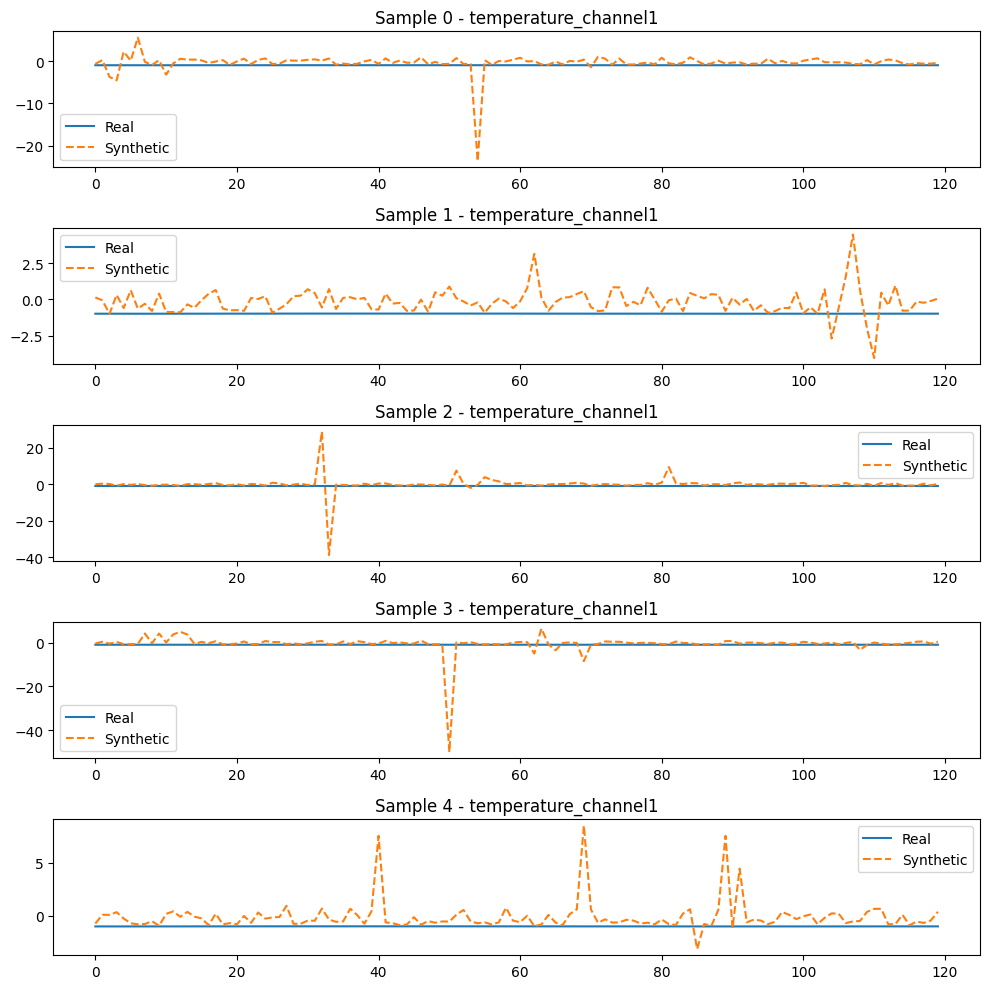

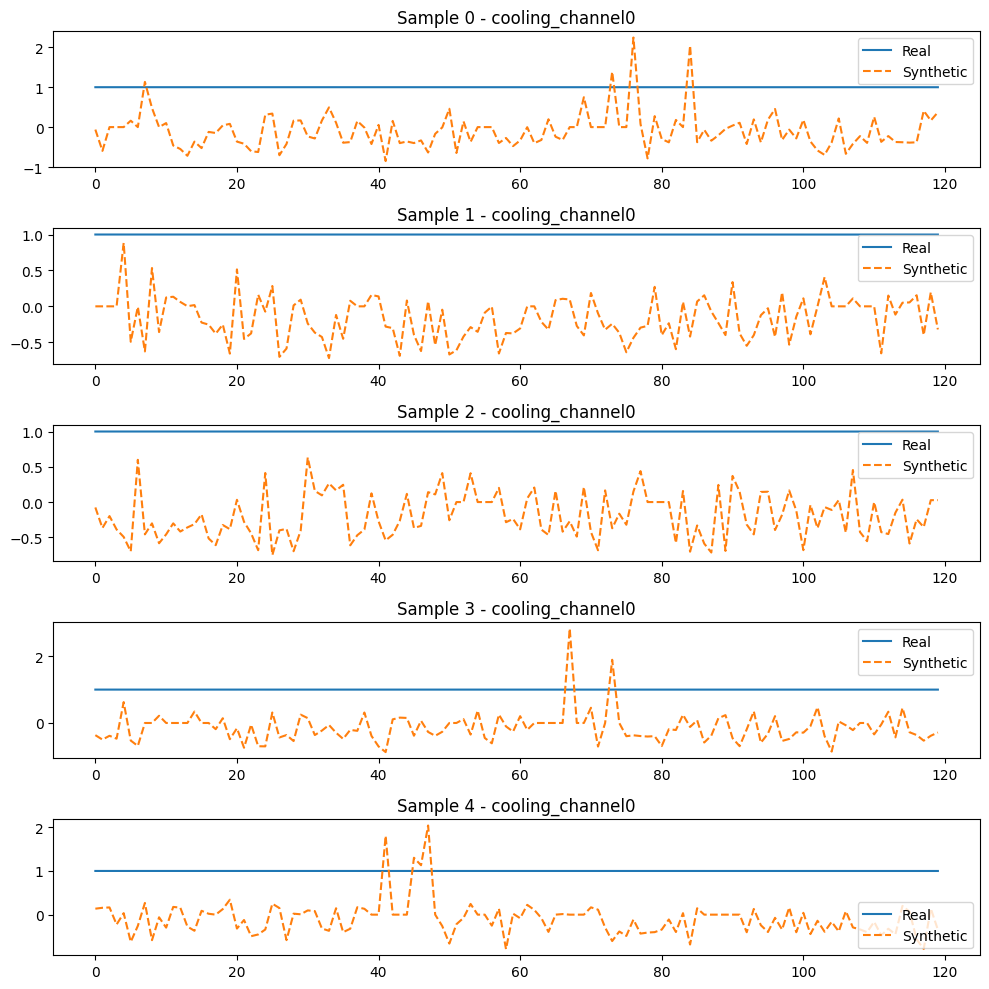

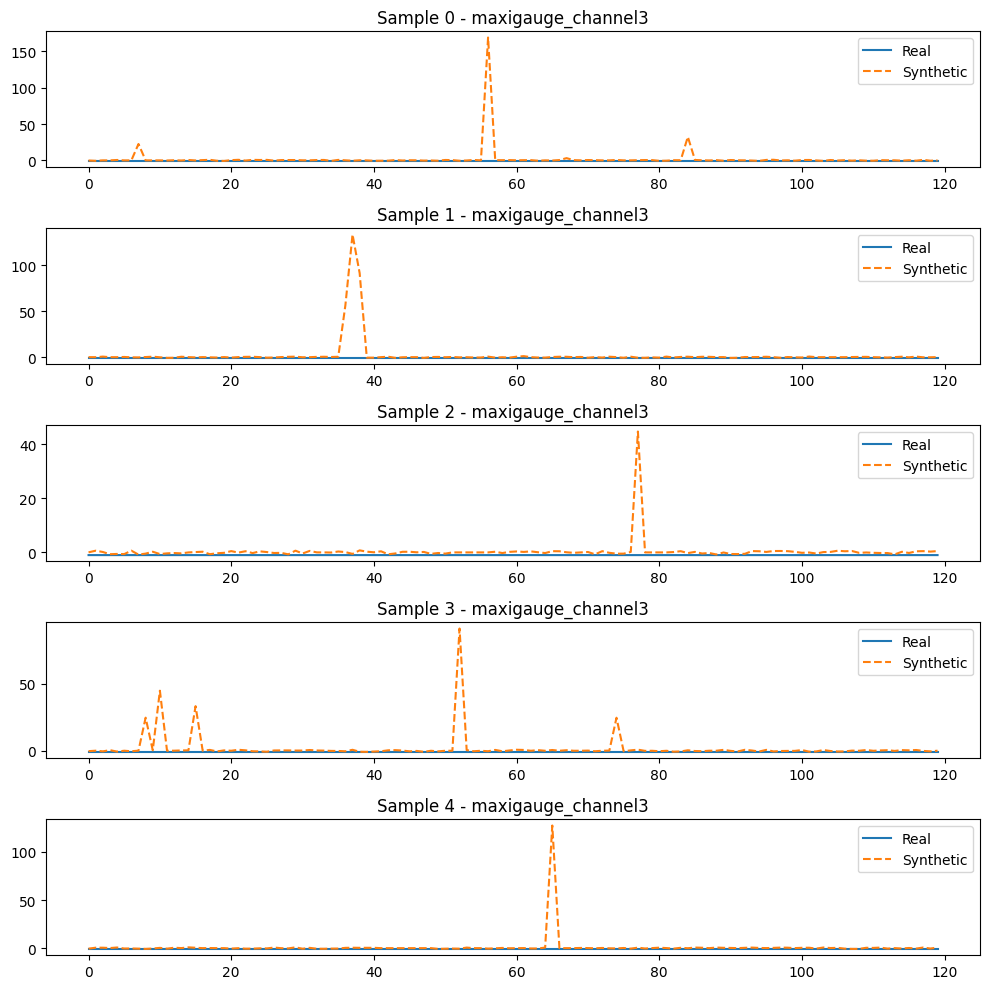

/Users/liqi/anaconda3/envs/tf310/lib/python3.10/site-packages/sklearn/utils/extmath.py:335: RuntimeWarning: divide by zero encountered in matmul
  Q, _ = normalizer(A @ Q)
/Users/liqi/anaconda3/envs/tf310/lib/python3.10/site-packages/sklearn/utils/extmath.py:335: RuntimeWarning: overflow encountered in matmul
  Q, _ = normalizer(A @ Q)
/Users/liqi/anaconda3/envs/tf310/lib/python3.10/site-packages/sklearn/utils/extmath.py:335: RuntimeWarning: invalid value encountered in matmul
  Q, _ = normalizer(A @ Q)
/Users/liqi/anaconda3/envs/tf310/lib/python3.10/site-packages/sklearn/utils/extmath.py:336: RuntimeWarning: divide by zero encountered in matmul
  Q, _ = normalizer(A.T @ Q)
/Users/liqi/anaconda3/envs/tf310/lib/python3.10/site-packages/sklearn/utils/extmath.py:336: RuntimeWarning: overflow encountered in matmul
  Q, _ = normalizer(A.T @ Q)
/Users/liqi/anaconda3/envs/tf310/lib/python3.10/site-packages/sklearn/utils/extmath.py:336: RuntimeWarning: invalid value encountered in matmul
  Q, 

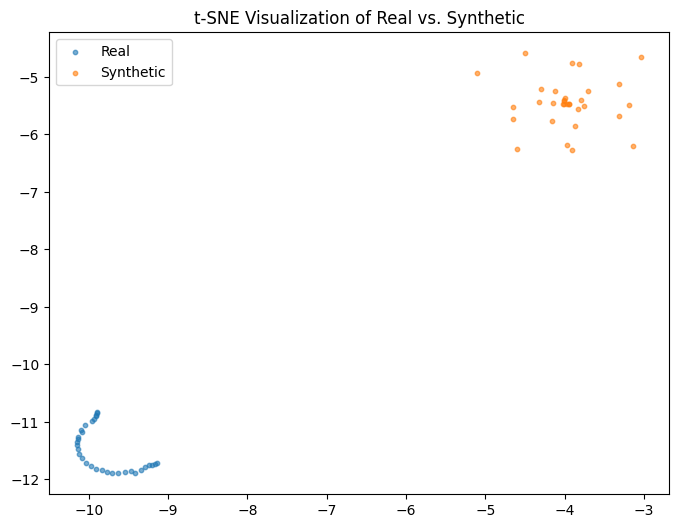

In [56]:
evaluator = TimeSeriesEvaluator(real_trimmed, synthetic_trimmed)
evaluator.evaluate_all(feature_names=column_names)